# Retrieve spectra from HEASARC using Simple Spectral Access protocol

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import requests, io
from astropy.table import Table
import xspec

In [2]:
## Sometimes this does nothing but time out!
#import astropy.coordinates as coord
#m82=coord.SkyCoord.from_name("m82")
#pos='{},{}'.format(m82.ra.deg,m82.dec.deg)
pos='148.968458,69.679703'
params = {'table': 'chanmaster',"POS":pos,"SIZE":".01", "REQUEST":"queryData"}
r = requests.get('https://heasarc.nasa.gov/xamin/vo/ssa', params=params)
spec_table = Table.read(io.BytesIO(r.content))
spec_table

obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_datalength,SSA_datamodel,SSA_title,SSA_instrument,SSA_publisher,SSA_tmid,SSA_stop_time,SSA_start_time,SSA_duration,SSA_bandpass,SSA_wavelength_max,SSA_wavelength_min,SSA_bandwidth,SSA_ra,SSA_dec,SSA_coord_obs,SSA_fov,SSA_reference,SSA_format
,,,deg,deg,mjd,,,s,,,mjd,,,,,,mjd,mjd,mjd,s,meter,meter,meter,meter,deg,deg,deg,deg,,
object,object,object,float64,float64,float64,object,object,float64,object,object,int32,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object
17860,archived,M82 X-1,148.95917,69.67972,57639.729200000002,ACIS-S,HETG,51060,TOO,Walton,58010,12.0,Spectrum-1.0,acisf17860N002_pha2,ACIS-S,HEASARC,57640.040393247451,57640.350814633915,57639.729200000002,51060.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,148.95917,69.679720000000003,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/17860/primary/acisf17860N002_pha2.fits.gz,application/fits
19791,archived,M82 X-1,148.95917,69.67972,57641.570200000002,ACIS-S,HETG,15310,TOO,Walton,58010,12.0,Spectrum-1.0,acisf19791N002_pha2,ACIS-S,HEASARC,57641.668022753758,57641.765065583451,57641.570200000002,15310.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,148.95917,69.679720000000003,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19791/primary/acisf19791N002_pha2.fits.gz,application/fits
19792,archived,M82 X-1,148.95917,69.67972,57642.353000000003,ACIS-S,HETG,32440,TOO,Walton,58010,12.0,Spectrum-1.0,acisf19792N002_pha2,ACIS-S,HEASARC,57642.558369954859,57642.762945849187,57642.353000000003,32440.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,148.95917,69.679720000000003,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19792/primary/acisf19792N002_pha2.fits.gz,application/fits


In [3]:
## Get the first spectrum (which has a long-ish exposure.)
import astropy.io.fits as fits
hdu_list=fits.open(spec_table[0]['SSA_reference'].decode()) # Byte format, so just decode() to string
#hdu_list.info()
table = Table(hdu_list[1].data)
table


SPEC_NUM,TG_M,TG_PART,TG_SRCID,X,Y,CHANNEL [8192],COUNTS [8192],STAT_ERR [8192],BACKGROUND_UP [8192],BACKGROUND_DOWN [8192],BIN_LO [8192],BIN_HI [8192]
int16,int16,int16,int16,float32,float32,int16,int16,float32,int16,int16,float64,float64
1,-3,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,7.15916666667 .. 0.333333333333,7.16 .. 0.334166666667
2,-2,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,10.73875 .. 0.5,10.74 .. 0.50125
3,-1,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,21.4775 .. 1.0,21.48 .. 1.0025
4,1,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,21.4775 .. 1.0,21.48 .. 1.0025
5,2,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,10.73875 .. 0.5,10.74 .. 0.50125
6,3,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,7.15916666667 .. 0.333333333333,7.16 .. 0.334166666667
7,-3,2,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,13.985 .. 0.333333333333,13.9866666667 .. 0.335
8,-2,2,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,20.9775 .. 0.5,20.98 .. 0.5025
9,-1,2,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,41.955 .. 1.0,41.96 .. 1.005


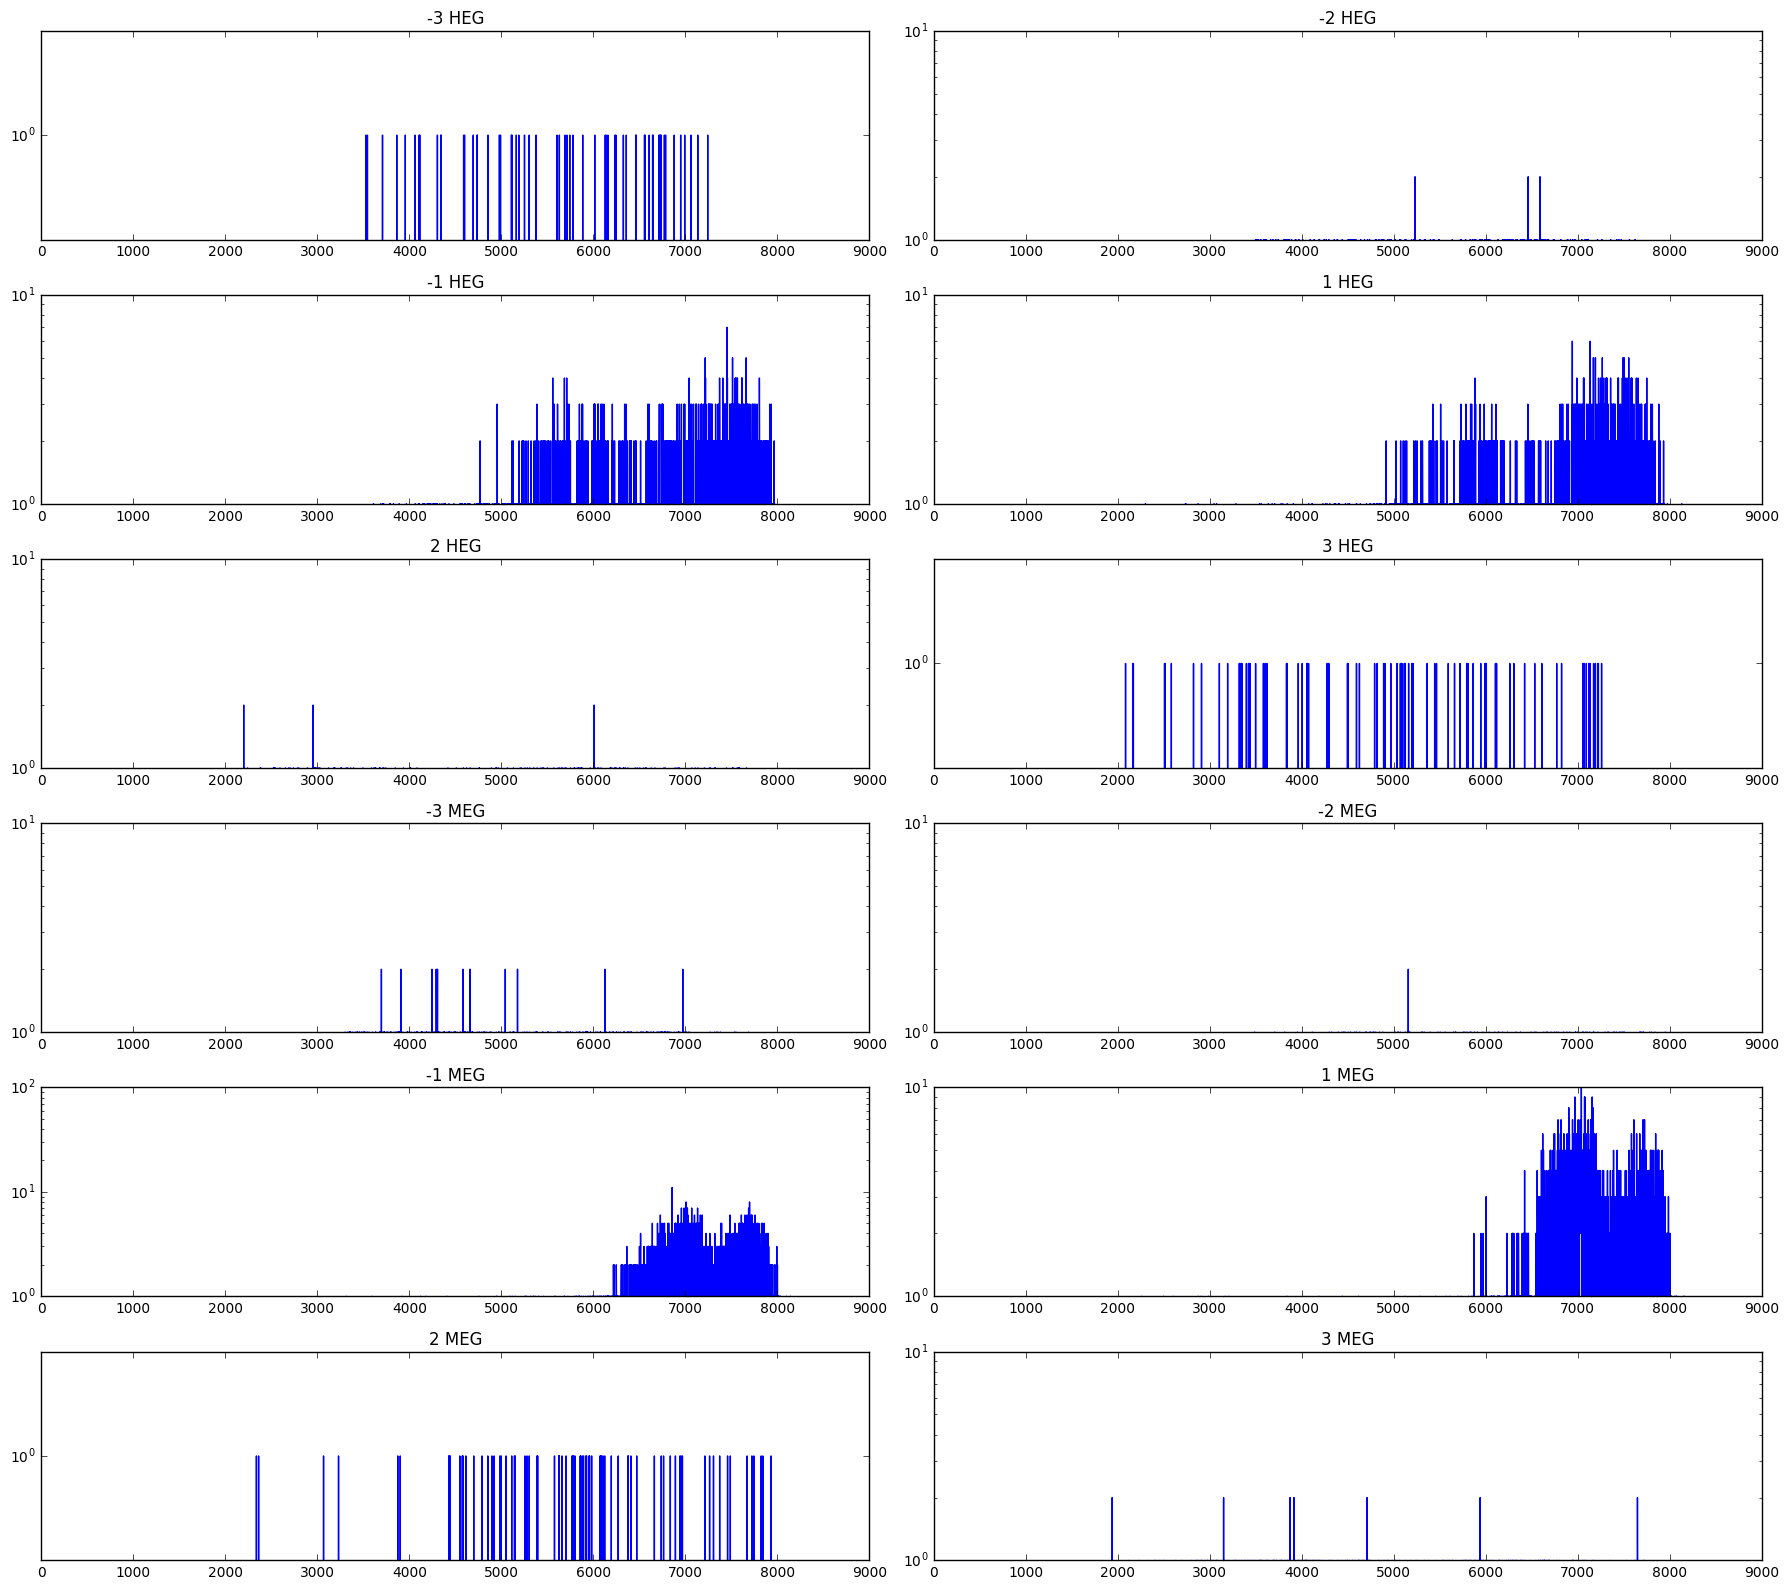

In [4]:
for i in range(len(table)):
    matplotlib.rcParams['figure.figsize'] = (18, 16)
    ax=plt.subplot(6,2,i+1)
    pha = plt.plot( table['CHANNEL'][i],table['COUNTS'][i])
    ax.set_yscale('log')
    if table['TG_PART'][i] == 1:
        instr='HEG'
    if table['TG_PART'][i] == 2:
        instr='MEG'
    if table['TG_PART'][i] == 3:
        instr='LEG'
    ax.set_title(str(table['TG_M'][i])+' '+instr)
    plt.tight_layout()
    

Note: The 12 plots here show all the different HEG and MEG components (+/- 3, +/- 2, and +/- 1 for each grating) for the grating data, as titled. In practice, you might want to download the fits file and use a different analysis and plotting tool to create an energy spectrum plot using SHERPA or XSPEC, etc. 

You can download the file directly using this:


In [5]:
## Because urllib is hard to make Python 2/3 compatible, just use requests:
r=requests.get(spec_table[0]['SSA_reference'].decode(), stream=True)
with open('my_M82_spectrum.fits','wb') as f:
    f.write(r.content)

And use it in Xspec!

<div class="alert alert-block alert-danger">
The output printed by Xspec appears in the terminal where jupyter was started.  This is a problem.
</div>

In [6]:
import xspec
xspec.Xset.allowPrompting = False # keeps pyxspec from hanging, waiting for a response to a prompt

specfile = "my_M82_spectrum.fits{1}"
meg_pha = xspec.Spectrum(specfile)


In [7]:
xspec.AllModels += "wa*po + ga"
